In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import glob
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.measure import label, regionprops
import math
import glob
import re
import json

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf

In [4]:
imagesf = glob.glob('/content/drive/MyDrive/Covid19/Preprocess-Data/Images/*.png')
masksf = [path.replace("Images", "Masks") for path in imagesf]
print(len(imagesf), len(masksf))

373 373


In [5]:
images = np.array([plt.imread(path) for path in imagesf])

In [6]:
masks = np.array([plt.imread(path) for path in masksf])

In [7]:
print(images.shape)
print(masks.shape)

(373, 256, 256, 3)
(373, 256, 256, 3)


In [8]:
masks = masks[..., 0:3] # eliminar el canal alpha
images = images[..., 0:3] # eliminar el canal alpha

In [9]:
print(images.shape)
print(masks.shape)

(373, 256, 256, 3)
(373, 256, 256, 3)


In [10]:
new_mask = np.zeros((len(masksf), 256, 256))

In [11]:
print(new_mask.shape)

(373, 256, 256)


In [12]:
rgb_colors = [[1.,0.,0.], [0.,1.,0.], [0.,0.,1.]]

In [13]:
for i, color in enumerate(rgb_colors):
    bool_mask = np.all(masks==color, axis=-1)
    new_mask[bool_mask] = i + 1

In [14]:
X = images
y = to_categorical(new_mask)

In [15]:
print(X.shape)
print(y.shape)

(373, 256, 256, 3)
(373, 256, 256, 3)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [17]:
n_classes = 3

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels, n_classes):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, n_classes, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [19]:
model = MultiResUnet(256, 256, 3, n_classes)

In [20]:
import tensorflow.keras.backend as K
from itertools import product
from functools import partial, update_wrapper

In [21]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.constant(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def IoU(a, b):
    overlap = np.all([a, b], axis=0).sum()
    union = np.any([a, b], axis=0).sum()
    return overlap/union

def color_mask(mask):
    new_mask = np.zeros((*mask.shape, 3))
    for i, color in enumerate(rgb_colors):
        bool_mask = mask==i+1
        new_mask[bool_mask] = color
    return new_mask

def calculate_metrics(predictions, true, threshold=0.51, true_labeled = None):
    vp = 0
    fp = 0
    fn = 0

    if true_labeled == None:
        true_labeled = label(true)
    else:
        true_labeled = true_labeled.copy()
    predictions_labeled = label(predictions)
    
    pred_labels = np.unique(predictions_labeled)
    pred_labels = pred_labels[pred_labels != 0]
    
    for pred_label in pred_labels:
        predicted_class = predictions[predictions_labeled == pred_label].max()
        intercepted_values = np.unique(true_labeled[(predictions_labeled == pred_label) & (true == predicted_class)])
        intercepted_values = intercepted_values[intercepted_values != 0]
        value_saved = None
        score_saved = 0
        for value in intercepted_values:
            score = IoU((predictions == pred_label).flatten(), (true == value).flatten())
            if (score >= threshold) and (score > score_saved):
                value_saved = value
                score_saved = score

        if value_saved == None:
            fp += 1
        else:
            true_labeled[true_labeled == value_saved] = 0
            vp += 1
            
    rest_values = np.unique(true_labeled)
    rest_values = rest_values[rest_values != 0]
    fn = len(rest_values)
    
    return {"vp": vp, "fp": fp, "fn": fn}

In [22]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [23]:
model.compile(optimizer='Adadelta', loss="categorical_crossentropy", metrics=['acc',jaccard_distance])

In [24]:
filepath = "/content/drive/MyDrive/Covid19/Weights/01/best_weight.hdf5"

In [25]:
MCP = ModelCheckpoint(filepath=filepath, save_best_only=True, save_weights_only=True)
callbacks = [MCP]

In [26]:
print(X_train.shape)
print(y_train.shape)

(335, 256, 256, 3)
(335, 256, 256, 3)


In [27]:
history = model.fit(X_train, y_train, batch_size=5, validation_data=(X_test, y_test), epochs=2000, callbacks=callbacks)

Epoch 1/2000
67/67 [==============================] - 20s 160ms/step - loss: 1.4167 - acc: 0.3286 - jaccard_distance: 1.4624 - val_loss: 0.9351 - val_acc: 0.9670 - val_jaccard_distance: 1.4043
Epoch 2/2000
67/67 [==============================] - 9s 129ms/step - loss: 1.4072 - acc: 0.3313 - jaccard_distance: 1.4617 - val_loss: 0.8404 - val_acc: 0.9328 - val_jaccard_distance: 1.3609
Epoch 3/2000
67/67 [==============================] - 9s 137ms/step - loss: 1.3997 - acc: 0.3368 - jaccard_distance: 1.4612 - val_loss: 0.8381 - val_acc: 0.8719 - val_jaccard_distance: 1.3551
Epoch 4/2000
67/67 [==============================] - 8s 122ms/step - loss: 1.3930 - acc: 0.3429 - jaccard_distance: 1.4609 - val_loss: 0.9291 - val_acc: 0.6197 - val_jaccard_distance: 1.3898
Epoch 5/2000
67/67 [==============================] - 8s 122ms/step - loss: 1.3868 - acc: 0.3488 - jaccard_distance: 1.4602 - val_loss: 1.0531 - val_acc: 0.4460 - val_jaccard_distance: 1.4329
Epoch 6/2000
67/67 [===================

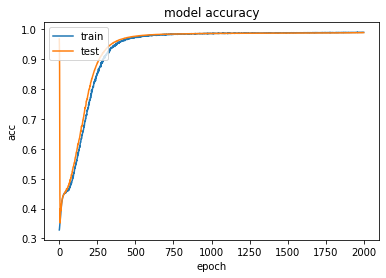

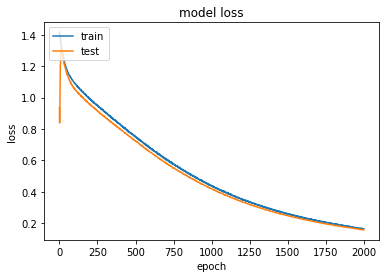

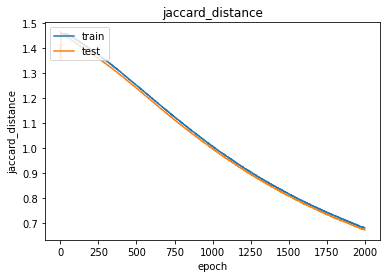

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['jaccard_distance'])
plt.plot(history.history['val_jaccard_distance'])
plt.title('jaccard_distance')
plt.ylabel('jaccard_distance')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
pred = model.predict(X_test)

In [30]:
from sklearn.metrics import classification_report
import seaborn as sns

In [31]:
print(classification_report(y_test.argmax(-1).flatten(), pred.argmax(-1).flatten()))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   2429988
           1       0.84      0.64      0.73     54652
           2       0.76      0.38      0.50      5728

    accuracy                           0.99   2490368
   macro avg       0.86      0.67      0.74   2490368
weighted avg       0.99      0.99      0.99   2490368



In [32]:
index_test = 8

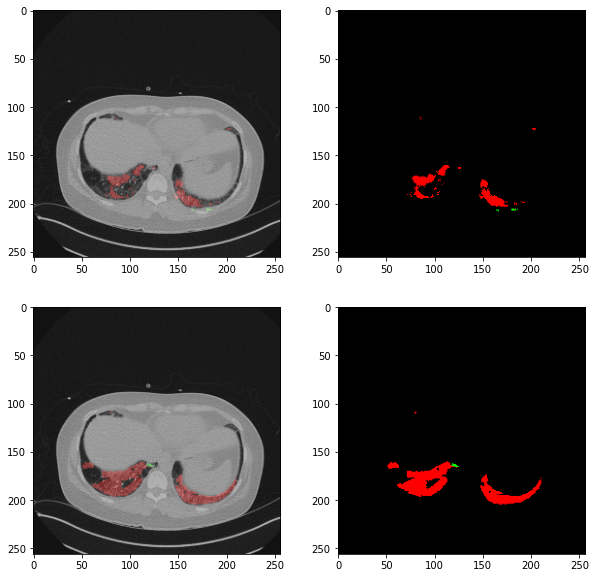

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(X_test[index_test]) # imagen
# mascara predicha convirtiendola a clases teniendo en cuenta la probabilidad mas alta para cada pixel
axs[0, 0].imshow(color_mask(pred[index_test].argmax(axis=2)), alpha=0.3)
axs[0, 1].imshow(color_mask(pred[index_test].argmax(axis=2))) 


axs[1, 0].imshow(X_test[index_test]) # imagen
axs[1, 0].imshow(color_mask(y_test[index_test].argmax(axis=2)), alpha=0.3) # mascara real
axs[1, 1].imshow(color_mask(y_test[index_test].argmax(axis=2))) # mascara real

In [34]:
index_test = 15

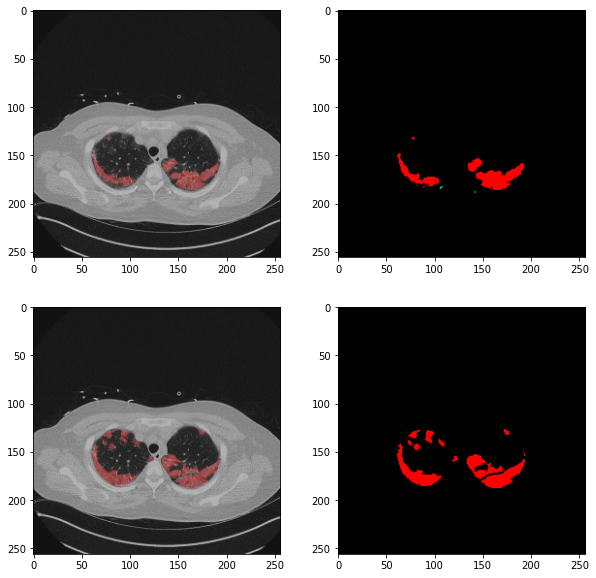

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(X_test[index_test]) # imagen
# mascara predicha convirtiendola a clases teniendo en cuenta la probabilidad mas alta para cada pixel
axs[0, 0].imshow(color_mask(pred[index_test].argmax(axis=2)), alpha=0.3)
axs[0, 1].imshow(color_mask(pred[index_test].argmax(axis=2))) 


axs[1, 0].imshow(X_test[index_test]) # imagen
axs[1, 0].imshow(color_mask(y_test[index_test].argmax(axis=2)), alpha=0.3) # mascara real
axs[1, 1].imshow(color_mask(y_test[index_test].argmax(axis=2))) # mascara real